In [8]:
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use('dark_background')


In [9]:
CPILFESL_df = pd.read_csv('data/inflation/CPILFESL.csv')

CPILFESL_df['DATE'] = pd.to_datetime(CPILFESL_df['DATE'])
CPILFESL_df.set_index('DATE', inplace=True)

CPILFESL_df['^ %'] = CPILFESL_df['CPILFESL'].pct_change() * 100

CPILFESL_df.tail()

,CPILFESL,^ %
DATE,,
2024-06-01,318.346,0.064751
2024-07-01,318.872,0.165229
2024-08-01,319.768,0.280990
2024-09-01,320.767,0.312414
2024-10-01,321.666,0.280266


---

- **Average change**

In [10]:
print(f"Average change is {CPILFESL_df['^ %'].mean()}")

Average change is 0.29885115576821936


- **Overview on change**

In [11]:
positive_filter = CPILFESL_df['^ %'] > 0
negative_filter = CPILFESL_df['^ %'] < 0
zero_filter = CPILFESL_df['^ %'] == 0

# count
total_items = len(CPILFESL_df)

# average change
avg_change = [
    CPILFESL_df[positive_filter]['^ %'].mean(),
    CPILFESL_df[negative_filter]['^ %'].mean(),
    0,
    ""
]

# frequency
frequency = [
    CPILFESL_df[positive_filter]['^ %'].count(),
    CPILFESL_df[negative_filter]['^ %'].count(),
    CPILFESL_df[zero_filter]['^ %'].count()
]
frequency.append(frequency[0]/frequency[1])

# frequency pct
frequency_pct = [100 * frequency[i]/total_items for i in range(3)]
frequency_pct.append("")

# Prob adj
prob_adj = [frequency_pct[i] * avg_change[i]/100 for i in range(3)]
prob_adj.append("")

pd.DataFrame({
    "%": avg_change,
    "Frequency": frequency,
    "Frequency %": frequency_pct,
    "Prob Adjust % Change": prob_adj,
}, index=["Av Pos", "Av Neg", "Zero", "Ratio P/N"])

,%,Frequency,Frequency %,Prob Adjust % Change
Av Pos,0.336569,729.00,89.55774,0.301424
Av Neg,-0.199403,12.00,1.474201,-0.00294
Zero,0,72.00,8.845209,0.0
Ratio P/N,,60.75,,


- **Stats**

In [12]:
from scipy.stats import describe

# Display the results

# print(f"Number of Observations: {stats.nobs}")
# print(f"Minimum: {stats.minmax[0]}")
# print(f"Maximum: {stats.minmax[1]}")
# print(f"Mean: {stats.mean}")
# print(f"Variance: {stats.variance}")
# print(f"Skewness: {stats.skewness}")
# print(f"Kurtosis: {stats.kurtosis}")

stats = describe(CPILFESL_df['^ %'].dropna().tolist())
pd.DataFrame(stats, index=[x for x in stats._fields], columns=['value'])

,value
nobs,813
minmax,"(-0.4762831937933365, 1.4193548387096744)"
mean,0.298851
variance,0.060262
skewness,1.307835
kurtosis,3.027254


- **Data preview**

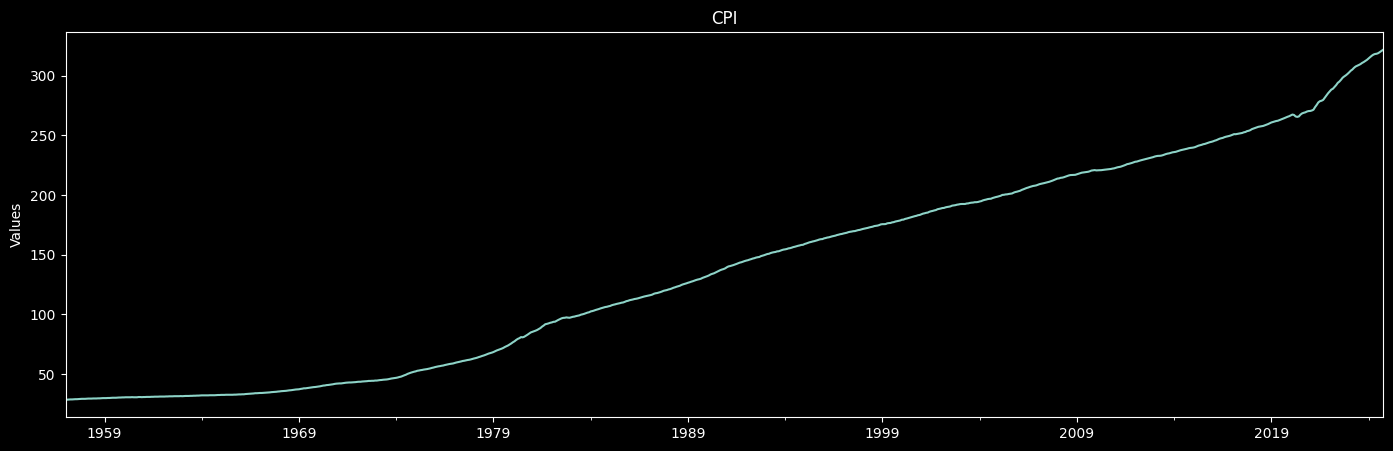

In [13]:
CPILFESL_df['CPILFESL'].plot(
    figsize=(17, 5),
    xlabel='',
    ylabel='Values',
    title='CPI',
);

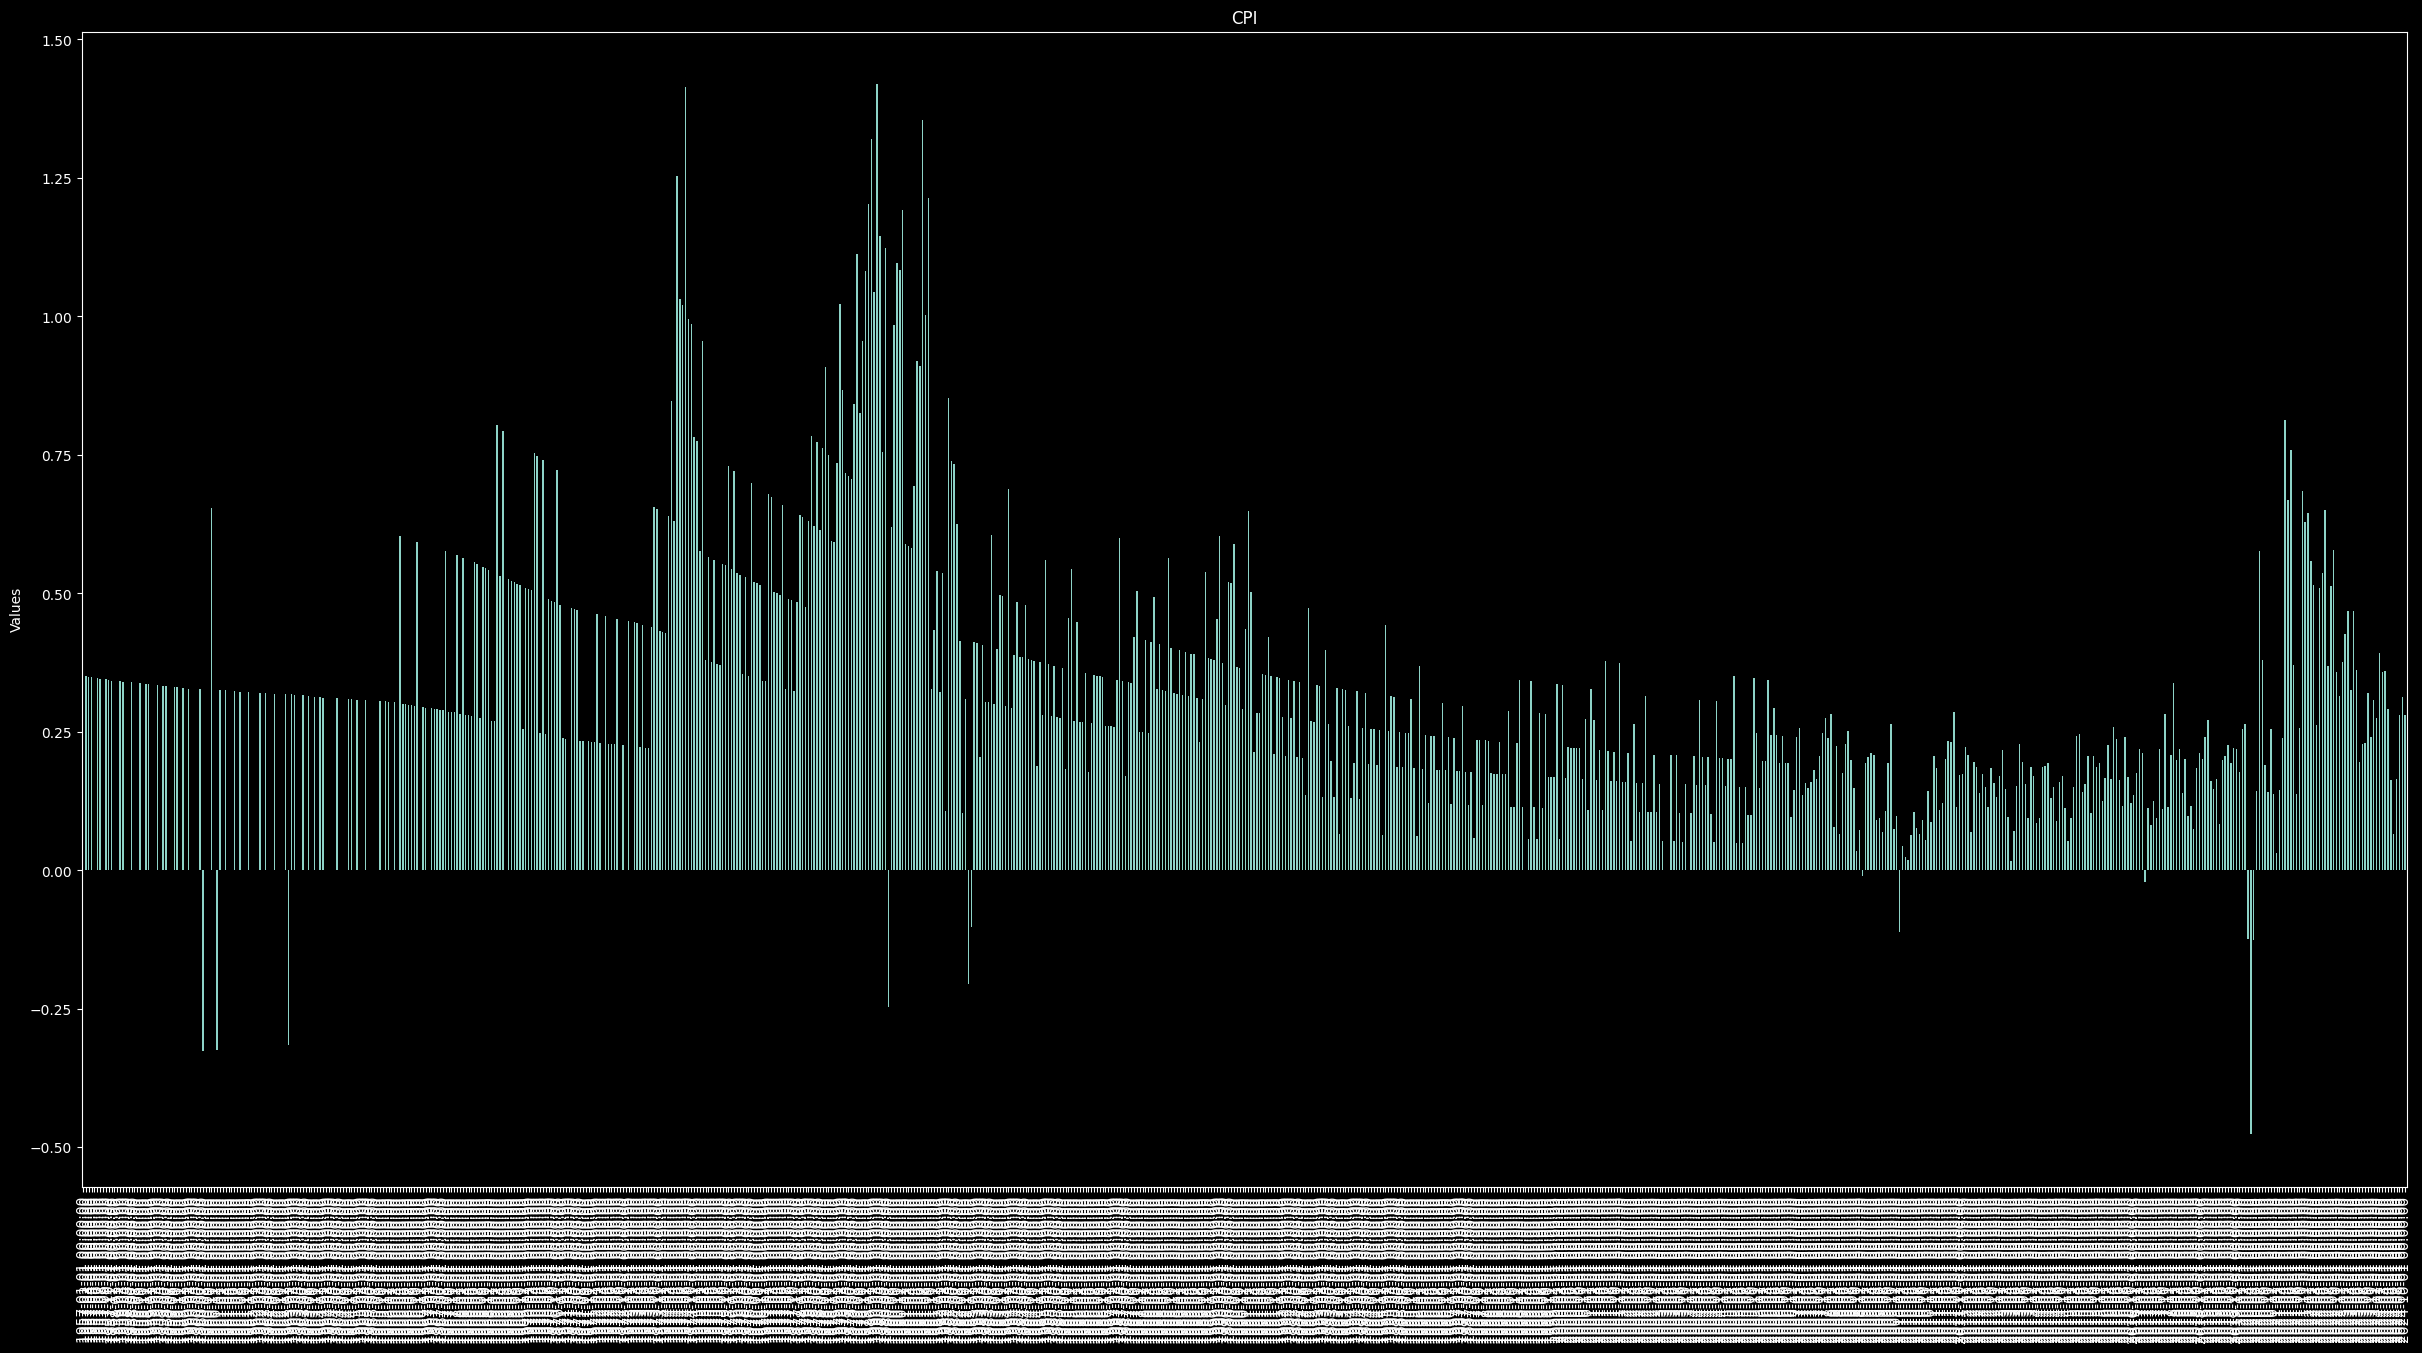

In [14]:
CPILFESL_df['^ %'].plot(
    kind='bar',
    figsize=(30, 15),
    xlabel='',
    ylabel='Values',
    title='CPI',
);